In [1]:
from qs_mps.mpo_class import MPO_ladder
from qs_mps.mps_class import MPS
from qs_mps.applications.Z2.exact_hamiltonian import H_Z2_gauss
from qs_mps.sparse_hamiltonians_and_operators import sparse_pauli_z, sparse_pauli_x
from qs_mps.utils import tensor_shapes, get_precision
import numpy as np

In [2]:
z2_mpo = MPO_ladder(l=2,L=3,model="Z2_dual", lamb=0)
z2_exact = H_Z2_gauss(l=3,L=3,model="Z2_dual", lamb=0)

In [3]:
cx = [2,0]
cy = [0,0]
z2_mpo.add_charges(cx,cy)
print(z2_mpo.charges)
z2_exact.add_charges(cx,cy)
print(z2_exact.charges)

[[-1.  1. -1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
[[-1.  1. -1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]


In [4]:
def thooft():
    z2_mpo.mpo_skeleton()
    mpo_tot = []
    for mpo_site in range(z2_mpo.L-1):
        if mpo_site == 0:
            z2_mpo.mpo[0,-1] = z2_mpo.charge_coeff_v(mpo_site=0, l=0) * sparse_pauli_z(n=1, L=z2_mpo.l).toarray()
        mpo_tot.append(z2_mpo.mpo)
        z2_mpo.mpo_skeleton()
    
    z2_mpo.mpo = mpo_tot
    return z2_mpo

In [5]:
z2_mpo_new = thooft()
tensor_shapes(z2_mpo_new.mpo)

(4, 4, 4, 4)
(4, 4, 4, 4)


[(4, 4, 4, 4), (4, 4, 4, 4)]

In [6]:
mps = MPS(L=3, d=2**2, model="Z2_dual", chi=4, h=0)
mps.load_sites("/Users/fradm98/Desktop/projects/1_Z2", cx=cx, cy=cy)

In [7]:
mps.w = z2_mpo_new.mpo
mps.L = 2
print(mps.mpo_first_moment())

(-0.9999999999999998+0j)


In [28]:
# define the initial guess state
dof = z2_exact.dof
c = (1/np.sqrt(2))**dof
v0 = [c]*(2**dof)
v0 = np.array(v0, dtype=complex)
e, v = z2_exact.diagonalize(v0, save=False, sparse=False)
psi = v[:,0]

In [29]:
print(psi[:10])

[-0.015625+0.j -0.015625+0.j -0.015625+0.j -0.015625+0.j  0.015625+0.j
  0.015625+0.j  0.015625+0.j  0.015625+0.j -0.015625+0.j -0.015625+0.j]


In [20]:
print(f"{z2_exact.latt._lattice_drawer.draw_lattice()}")
print(z2_exact.charges)

      +-- 7--+-- 8--+-- 9--+      
      |      |      |      |      
      14     15     16     17
      |      |      |      |      
      +-- 4--+-- 5--+-- 6--+      
      |      |      |      |      
      10     11     12     13
      |      |      |      |      
      +-- 1--+-- 2--+-- 3--+      

[[-1.  1.  1. -1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]


In [31]:
print(z2_exact.latt.plaquettes(from_zero=True)[0])

(0, 7, 2, 6)


In [37]:
op = sparse_pauli_x(n=6,L=z2_exact.dof) @ sparse_pauli_x(n=11,L=z2_exact.dof)

In [38]:
print(psi.T @ op @ psi)

(-1.000000000000019+0j)


In [19]:
E_h = np.zeros((2*3-1,2*4-1))
E_h[:] = np.nan
z2_exact.electric_field(psi=psi, E=E_h)

array([[        nan, -0.01231739,         nan,  0.08268206,         nan,
        -0.01231739,         nan],
       [ 0.01231739,         nan,  0.04894271,         nan,  0.04894271,
                nan,  0.01231739],
       [        nan,  0.05022732,         nan,  0.03846314,         nan,
         0.05022732,         nan],
       [ 0.20708399,         nan,  0.07378442,         nan,  0.07378442,
                nan,  0.20708399],
       [        nan,  0.20708399,         nan,  0.12975675,         nan,
         0.20708399,         nan]])

Try a phase diagram plot

In [19]:
l = 4
L = 3
z2_exact = H_Z2_gauss(l=l,L=L,model="Z2_dual", lamb=0)
print(f"{z2_exact.latt._lattice_drawer.draw_lattice()}")
z2_exact.add_charges(rows=[0,2],columns=[0,0])
print(z2_exact.charges)
plaq_tot = z2_exact.latt.plaquettes()

      +-- 7--+-- 8--+      
      |      |      |      
      15     16     17
      |      |      |      
      +-- 5--+-- 6--+      
      |      |      |      
      12     13     14
      |      |      |      
      +-- 3--+-- 4--+      
      |      |      |      
      9      10     11
      |      |      |      
      +-- 1--+-- 2--+      

[[-1.  1. -1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]


### Vertical strings for ED

In [18]:
mpo_site = 0
r=1
plaq_tot_spl = np.array_split(plaq_tot, L-1)
plaqs = [pl for pl in plaq_tot_spl[mpo_site]].copy()
# plaqs.reverse()
pauli = []
for i in range(l-r-1):
    pauli = pauli + [plaqs[i][0]]
print(pauli)

[1, 3]


### Horizontal strings for ED

In [45]:
mpo_site = 2
L=5
l=2
plaq_tot_spl = np.array_split(plaq_tot, L-1)
plaqs = np.swapaxes(plaq_tot_spl, axis1=0, axis2=1)
plaqs = [pl for pl in plaqs].copy()
plaqs.reverse()
plaqs_h = plaqs[l].copy()
pauli = []
for i in range(mpo_site+1):
    pauli = pauli + [plaqs_h[i][3]]
print(pauli)

[17, 18, 19]


In [15]:
from scipy.sparse import identity
h_i = 0
h_f = 10
npoints = 10
hs = np.linspace(h_i,h_f,npoints)
num = (h_f - h_i) / npoints
precision = get_precision(num)
cx = [2,0]
cy = [0,0]
l=4
L=3
dof = 2*l*L -l - L
op = identity(n=2**dof)
for idx in pauli:
    op = op @ sparse_pauli_x(n=idx,L=dof)

thooft_mpo = []
thooft_ed = []
for h in hs:
    print(f"Computing `t Hooft string for h: {h:.1f}")
    mps = MPS(L=L, d=2**(l-1), model="Z2_dual", chi=2**(l-1), h=h)
    mps.L = L-1
    mps.load_sites("/Users/fradm98/Desktop/projects/1_Z2", precision=precision, cx=cx, cy=cy)
    mps.Z2.add_charges(cx,cy)
    mps.Z2.thooft(site=[0], l=[1], direction="vertical")
    mps.w = mps.Z2.mpo.copy()
    
    thooft_mpo.append(mps.mpo_first_moment().real)

    z2_exact = H_Z2_gauss(l=l,L=L,model="Z2_dual", lamb=h)
    z2_exact.add_charges(cx,cy)
    dof = z2_exact.dof
    c = (1/np.sqrt(2))**dof
    v0 = [c]*(2**dof)
    v0 = np.array(v0, dtype=complex)
    e, v = z2_exact.diagonalize(v0, cx=cx, cy=cy, precision=precision, path="/Users/fradm98/Desktop/projects/1_Z2")
    psi = v[:,0]
    # np.load("/Users/fradm98/Desktop/projects/1_Z2/results/eigenvectors/")
    thooft_ed.append((psi.T.conjugate() @ op @ psi).real)

Computing `t Hooft string for h: 0.0
Computing `t Hooft string for h: 1.1
Computing `t Hooft string for h: 2.2
Computing `t Hooft string for h: 3.3
Computing `t Hooft string for h: 4.4
Computing `t Hooft string for h: 5.6
Computing `t Hooft string for h: 6.7
Computing `t Hooft string for h: 7.8
Computing `t Hooft string for h: 8.9
Computing `t Hooft string for h: 10.0


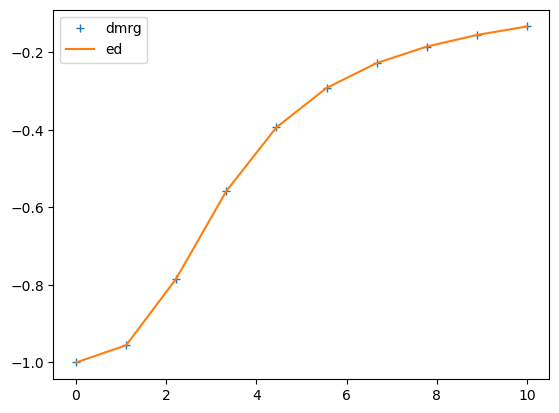

In [16]:
import matplotlib.pyplot as plt

plt.plot(hs, thooft_mpo, '+', label='dmrg')
plt.plot(hs, thooft_ed, label='ed')
plt.legend()
plt.show()